# Example of a Dirichlet Process Mixture Model clustering using Gaussians

In [1]:
using DataFrames

# number of samples per cluster
N = 100

# create clusters
Data = DataFrame( x = randn(N), y = randn(N), class = "cluster1" )

# append second cluster
append!(Data, DataFrame( x = randn(N) + 5, y = randn(N) + 5, class = "cluster2" ));

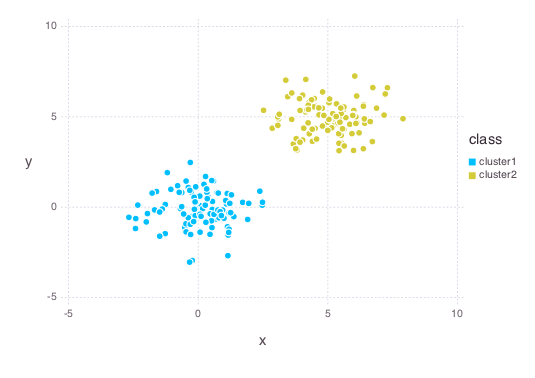

In [2]:
# visualize data
using Gadfly

plot(Data, x = :x, y = :y, color = :class)

## train DPM using collabsed Gibbs sampling

In [3]:
using BNP

D = 2 # 2 dimensional data
N = 200 # number of data points

# data matrix
X = zeros(D, N)

X[1,:] = convert(Array, Data[:x])
X[2,:] = convert(Array, Data[:y])

# init base distribution parameters
mu0 = vec(mean(X, 2))
kappa0 = 9.0
nu0 = 5.0
Sigma0 = eye(D) * 10

# base distribution and concentration parameter (Gaussian with Normal Inverse Wishart Prior)
H = GaussianWishart(mu0, kappa0, nu0, Sigma0)

# train Dirichlet Process Mixture Model
result = train(DPM(H), Gibbs(), RandomInitialisation(k = 10), X);

## visualize inferred models

Interact.Slider{Int64}([Reactive.Input{Int64}] 50,"iteration",50,1:100)

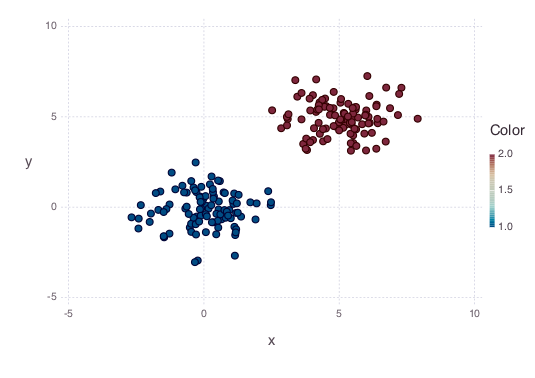

In [5]:
using Interact

K = zeros(Int, N)

# interactively loop over all iterations
@manipulate for iteration = 1:size(result, 1)
    
    idx = unique(result[iteration].Z)
    
    for n in 1:N
        K[n] = findfirst(idx .== result[iteration].Z[n])
    end

    plot(x = X[1,:], y = X[2,:], color = K)
    
end

## visualize energy function

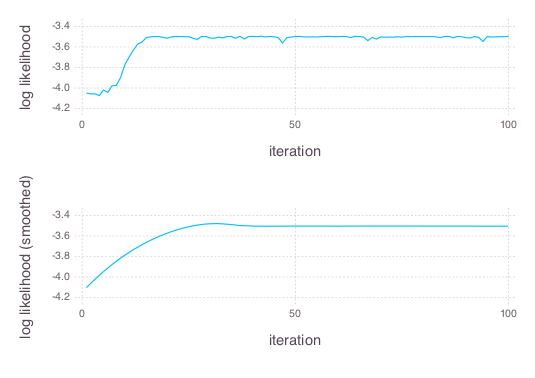

In [6]:
LLH = map(x -> x.energy, result)

# plot
p1 = plot( x = collect(1:size(result, 1)), 
            y = LLH, 
            Geom.line,
            Guide.xlabel("iteration"), 
            Guide.ylabel("log likelihood", orientation=:vertical) )

p2 = plot( x = collect(1:size(result, 1)), 
            y = LLH, 
            Geom.smooth,
            Guide.xlabel("iteration"), 
Guide.ylabel("log likelihood (smoothed)", orientation=:vertical) )

# stack together
vstack(p1, p2)

## visualize further information

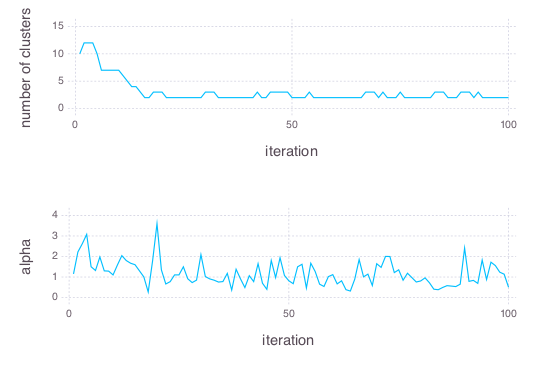

In [7]:
# number of clusters
C = [length(unique(x.Z)) for x in result]

# alpha parameter
A = map(x -> x.α, result)

# plot
p1 = plot( x = collect(1:size(result, 1)), 
            y = C, Geom.line, 
            Guide.xlabel("iteration"), 
            Guide.ylabel("number of clusters", orientation=:vertical) )
p2 = plot( x = collect(1:size(result, 1)), 
            y = A, 
            Geom.line, 
            Guide.xlabel("iteration"), 
            Guide.ylabel("alpha", orientation=:vertical) )

# stack together
vstack(p1, p2)